<a href="https://colab.research.google.com/github/anupj/PyTorchForDeepLearningBootcamp/blob/main/02_PyTorch_Neural_Network_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. NN classification with PyTorch

Book version of this notebook - https://www.learnpytorch.io/02_pytorch_classification/

Ask a question here - https://github.com/mrdbourke/pytorch-deep-learning/discussions

## 1. Create classification data and get it in shape


In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_circles

n_samples = 1000

# X = features
# y = labels
# `make_circles` produces Gaussian data with spherical decision boundary for binary classification [source: https://scikit-learn.org/dev/datasets/sample_generators.html#sample-generators]
# It is particularly useful for testing binary classification algorithms
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

From ChatGPT:

The `make_circles` function in scikit-learn's `datasets` module generates a simple synthetic dataset for binary classification tasks. It creates two concentric circles, making it useful for testing algorithms that can handle non-linear decision boundaries.

**Function Signature:**

```python
sklearn.datasets.make_circles(
    n_samples=100,
    *,
    shuffle=True,
    noise=None,
    random_state=None,
    factor=0.8
)
```

**Parameters:**

- `n_samples` (int or tuple of shape (2,), default=100):
  - If an integer, it specifies the total number of points generated.
  - If a tuple, it defines the number of points in the outer and inner circles, respectively.

- `shuffle` (bool, default=True): Whether to shuffle the samples.

- `noise` (float, default=None): Standard deviation of Gaussian noise added to the data.

- `random_state` (int, RandomState instance, or None, default=None): Determines random number generation for dataset shuffling and noise.

- `factor` (float, default=0.8): Scale factor between the inner and outer circle, in the range [0, 1).

**Returns:**

- `X` (ndarray of shape (n_samples, 2)): The generated samples.

- `y` (ndarray of shape (n_samples,)): The integer labels (0 or 1) for class membership of each sample.

**Example Usage:**

```python
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt

# Generate dataset
X, y = make_circles(n_samples=500, noise=0.05, factor=0.5, random_state=42)

# Plot the dataset
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolor='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Synthetic dataset using make_circles")
plt.show()
```

This function is particularly useful for testing classifiers that need to learn non-linear decision boundaries, such as kernel-based SVMs or neural networks.

### Why Use `make_circles`?

This dataset is useful for testing machine learning models that can handle **non-linear classification** problems, such as:
- **Kernel Support Vector Machines (SVMs)**, where the kernel trick can create a non-linear decision boundary.
- **Neural networks**, which can learn complex, non-linear boundaries.

In summary, `make_circles` is a great tool for experimenting with classifiers on non-linear datasets and understanding how they perform when the classes are separable only by a circular boundary.

In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
print(f"First five samples of X: {X[:5]}")
print(f"First five samples of y: {y[:5]}")

First five samples of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First five samples of y: [1 1 1 1 0]


In [5]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1],
                       "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


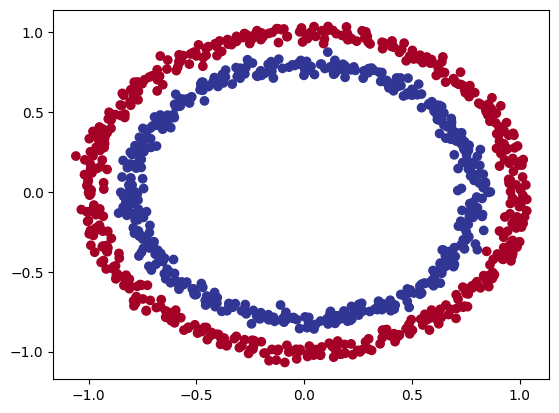

In [6]:
# Visualise
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

Note: The data we're working with is often referred to as a toy dataset - small enough to experiment but still sizeable enough t practice the fundamentals.

### 1.1. Check input and output shapes

In [7]:
# these are currently NumPy arrays
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Sample input features: {X_sample}")
print(f"Sample label: {y_sample}")
print(f"Type of X: {type(X_sample)}")
print(f"Type of y: {type(y_sample)}")
print(f"Shape of X: {X_sample.shape}")
print(f"Shape of y: {y_sample.shape}")

Sample input features: [0.75424625 0.23148074]
Sample label: 1
Type of X: <class 'numpy.ndarray'>
Type of y: <class 'numpy.int64'>
Shape of X: (2,)
Shape of y: ()


### 1.2. Turn our dataset into Tensors and split it
..and create train and test splits

In [9]:
import torch
torch.__version__

'2.5.0+cu121'

In [10]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [11]:
type(X), type(y), X.dtype, y.dtype

(torch.Tensor, torch.Tensor, torch.float32, torch.float32)

In [12]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split
# 02. = 20% of data will be test and 80% will be training
# random_state: equivalent of torch.manual_seed() to get similar random splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to:
1. Setup device agnostic code so our code will run on an accelerator (GPU) if there is one
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimiser
4. Create a training and test loop

In [14]:
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [15]:
X_train

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]])

In [16]:
# 1. Construct a model by subclassing `nn.Module`
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    self.layer_2 = nn.Linear(in_features=5, out_features=1)

  # 3. Define a forward() method that outlines the forward pass
  def forward(self, x):
    return self.layer_2(self.layer_1(x))

# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [17]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [18]:
# Let's replicate the model above using nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [19]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[-1.0357],
        [-0.9705],
        [-0.6417],
        [-1.1497],
        [ 0.2552],
        [ 0.2881],
        [-0.2391],
        [ 0.0579],
        [-0.6801],
        [-0.9562]], device='cuda:0')

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimiser

* Loss function measures how *wrong* your models predictions are.
* Choosing a loss function:
  - For regression, you might want Mean Absolute Error or Mean Squared Error
  - For classification, you might want binary cross entropy or categorical cross entropy
* Optimizers minimise the loss function during the training of NN by adjusting the weights and biases of the model - e.g. are SGD, Adam, Adagrad etc

We will use `torch.nn.BCEWithLogitsLoss()` for loss function, and for optimisers we will use `SGD`



In [20]:
# Setup the loss function
loss_fn = nn.BCEWithLogitsLoss() # this combines both loss function and activation function (Sigmoid)

# Set the optimiser
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

# Calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

## 3. Train model

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (backpropagation)
5. Optimizer step (gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**.

We can convert these **logits** into *prediction probabilities* by passing them to some kind of activation function (e.g. sigmoid for binary clasification and softmax for multiclass classification).

Then we can convert model's prediction probs to **prediction labels** by either rounding them (for binary classification) or taking the `argmax()`(for multiclass classification).

For our prediction probability values, we need to perform a range-style rounding on them:

* `y_pred_probs` > 0.5, y = 1 (class 1)
* `y_pred_probs` < 0.5, y = 0 (class 0)

### 3.2 Building training and testing loop

In [21]:
# Set manual seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set epoch
epochs = 3000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
  # TRAINING
  model_0.train()

  ## 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  ## turn logits -> pred probs -> pred labels
  y_pred_labels = torch.round(torch.sigmoid(y_logits))

  ## 2. Calculate the loss/accuracy
  ## remember `loss_fn` is `BCEWithLogitsLoss`
  ## therefore we pass in `y_logits` instead of `y_pred_labels`
  loss = loss_fn(y_logits,
                 y_train)
  acc = accuracy(y_true=y_train,
                 y_pred=y_pred_labels)

  ## 3. Set zero grad for the optimizer
  optimizer.zero_grad()

  ## 4. Loss backward backpropagation
  loss.backward()

  ## 5. optimizer step, step, step - gradient descent
  optimizer.step()

  # TESTING
  ## Put the model in `eval` mode
  model_0.eval()
  ## Always test with inference mode on to switch off
  ## training params
  with torch.inference_mode():
    ## 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred_labels = torch.round(torch.sigmoid(test_logits))

    ## 2. Calculate test loss/accuracy
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy(y_true=y_test,
                        y_pred=test_pred_labels)

  # PRINT OUT OUTPUT
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%  ")
    print(f"-------------------------------------------------------------")



Epoch: 0 | Loss: 0.74937, Acc: 47.75% | Test Loss: 0.73839, Test Acc: 47.50%  
-------------------------------------------------------------
Epoch: 10 | Loss: 0.72388, Acc: 48.25% | Test Loss: 0.71530, Test Acc: 47.50%  
-------------------------------------------------------------
Epoch: 20 | Loss: 0.71270, Acc: 48.38% | Test Loss: 0.70559, Test Acc: 48.00%  
-------------------------------------------------------------
Epoch: 30 | Loss: 0.70690, Acc: 49.75% | Test Loss: 0.70090, Test Acc: 48.50%  
-------------------------------------------------------------
Epoch: 40 | Loss: 0.70343, Acc: 49.62% | Test Loss: 0.69835, Test Acc: 49.50%  
-------------------------------------------------------------
Epoch: 50 | Loss: 0.70113, Acc: 50.38% | Test Loss: 0.69682, Test Acc: 49.00%  
-------------------------------------------------------------
Epoch: 60 | Loss: 0.69947, Acc: 50.50% | Test Loss: 0.69583, Test Acc: 48.50%  
-------------------------------------------------------------
Epoch: 

## 4. Make predictions and evaluate the model

Based on the metrics above, it looks like our model isn't learning anything, its no better than a coin toss. So, let's inspect it and make some predictions and make them visual i.e. *Visualise*, *Visualise*, *Visualise*!

We are going to import a helper function called `plot_decision_boundary()` -

In [22]:
import requests
from pathlib import Path

# Download helper fns from Learn PyTorch github repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
  print("`helper_functions.py` already exists, skipping download")
else:
  print("Download `helper_functions.py`")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary


Download `helper_functions.py`


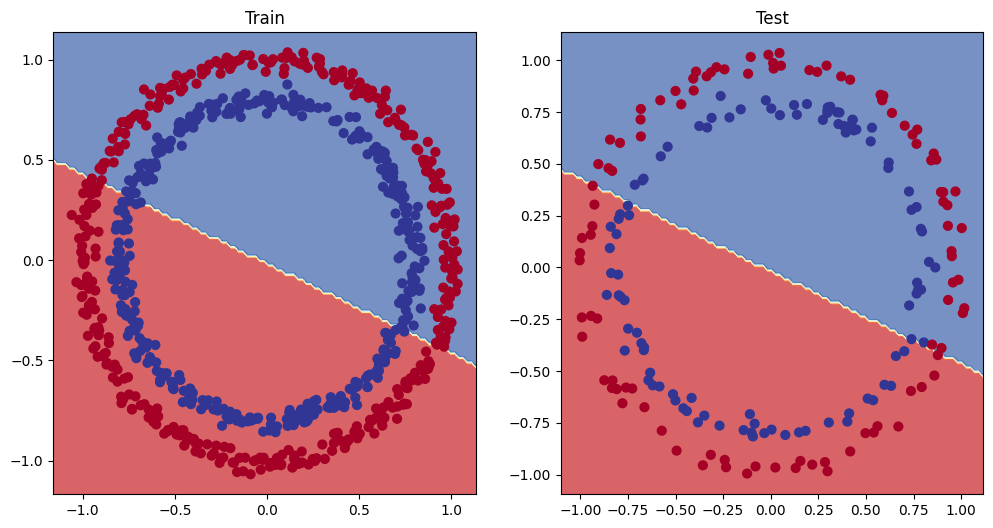

In [23]:
# Plot decision boundary of the model 0
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving the model (from a model perspective)

What are the options to improve the model?
* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from five hidden units (out features, in features) to 10 hidden units
* Fit for longer - more epochs
* Changing the activation functions
* Change the learning rate (lr)
* Change the loss function

These options are all from the model's perspective because they affect the Model rather than the data.

In [24]:
# Improving the `v0` model by:
# - Adding more hidden units: 5 -> 10
# - Increase the number of layers: 2 -> 3
# - Increase the number of epochs: 100 -> 1000
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    # z is logits
    # z = self.layer_1(x)
    # z = self.layer_2(z)
    # z = self.layer_3(z)
    # return z
    ## OR do it in one line like this
    ## this method is preferred because it leverages
    ## speed ups where possible behind the scenes
    return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1


CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [25]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr = 0.1)

In [26]:
# Write training and evaluation loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train for longer
epochs = 1000

# Put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ### Training
  model_1.train()

  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred_labels = torch.round(torch.sigmoid(y_logits))

  # 2. Calculate the loss and accuracy
  loss = loss_fn(y_logits, y_train)
  acc = accuracy(y_true=y_train,
                 y_pred= y_pred_labels)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred_labels = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate loss
    test_loss = loss_fn(test_logits,
                        y_test)

    test_acc = accuracy(y_true=y_test,
                        y_pred=test_pred_labels)

    # Print out what's happening
    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}%, Acc: {acc:.2f} | Test loss: {test_loss:.5f}, Test acc: {test_acc: 2f}%")

Epoch: 0 | Loss: 0.69396%, Acc: 50.88 | Test loss: 0.69261, Test acc:  51.000000%
Epoch: 100 | Loss: 0.69305%, Acc: 50.38 | Test loss: 0.69379, Test acc:  48.000000%
Epoch: 200 | Loss: 0.69299%, Acc: 51.12 | Test loss: 0.69437, Test acc:  46.000000%
Epoch: 300 | Loss: 0.69298%, Acc: 51.62 | Test loss: 0.69458, Test acc:  45.000000%
Epoch: 400 | Loss: 0.69298%, Acc: 51.12 | Test loss: 0.69465, Test acc:  46.000000%
Epoch: 500 | Loss: 0.69298%, Acc: 51.00 | Test loss: 0.69467, Test acc:  46.000000%
Epoch: 600 | Loss: 0.69298%, Acc: 51.00 | Test loss: 0.69468, Test acc:  46.000000%
Epoch: 700 | Loss: 0.69298%, Acc: 51.00 | Test loss: 0.69468, Test acc:  46.000000%
Epoch: 800 | Loss: 0.69298%, Acc: 51.00 | Test loss: 0.69468, Test acc:  46.000000%
Epoch: 900 | Loss: 0.69298%, Acc: 51.00 | Test loss: 0.69468, Test acc:  46.000000%


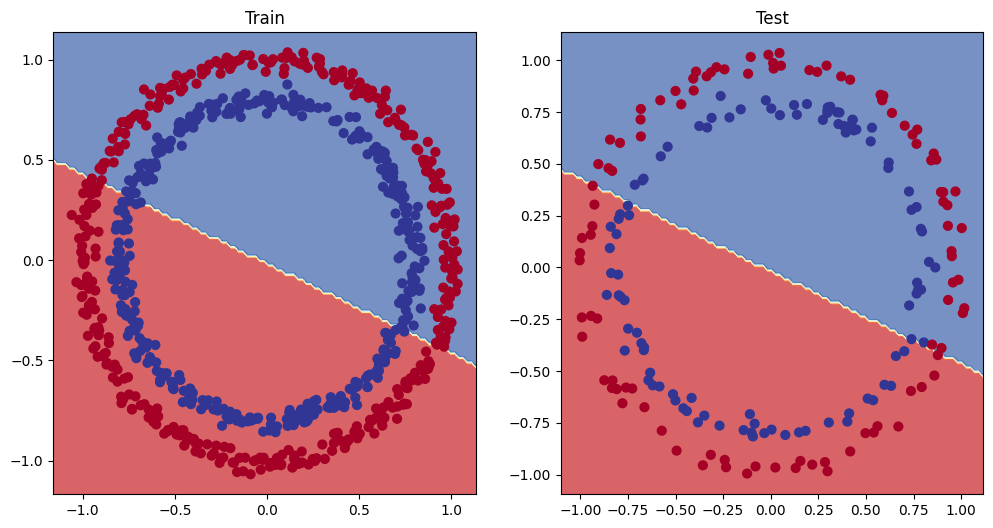

In [27]:
# Plot decision boundary of the model 1
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can fit a straight line

One way to troubleshoot a larger problem is to test out a smaller problem.

In [28]:
# Create same data that is linear in nature (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # same as Linear regression formula (without epsilon)

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [29]:
# Create training and test data splits
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]

X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lenghts of each
len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

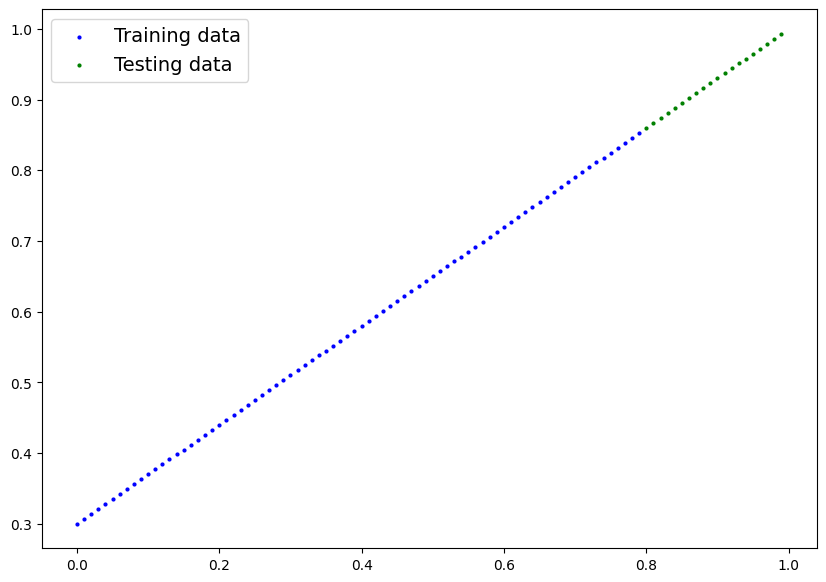

In [30]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

In [31]:
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

### 5.2 Adjusting `model_1` to fit a straight line

We need to adjust the in_features and out_features of model_1 because the data's shape has one input and one output.

In [32]:
# Same architecture as model_1 (but using nn.Sequential)
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1),
).to(device)
model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [33]:
# Loss and optimizer
loss_fn = nn.L1Loss() # MAE loss
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.01)

In [34]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put the data on the target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# Training
for epoch in range(epochs):
  y_pred = model_2(X_train_regression)
  loss = loss_fn(y_pred, y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing
  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test_regression)
    test_loss = loss_fn(test_pred, y_test_regression)

  # Print out what's happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}")



Epoch: 0 | Loss: 0.75986 | Test loss: 0.91103
Epoch: 100 | Loss: 0.02858 | Test loss: 0.00081
Epoch: 200 | Loss: 0.02533 | Test loss: 0.00209
Epoch: 300 | Loss: 0.02137 | Test loss: 0.00305
Epoch: 400 | Loss: 0.01964 | Test loss: 0.00341
Epoch: 500 | Loss: 0.01940 | Test loss: 0.00387
Epoch: 600 | Loss: 0.01903 | Test loss: 0.00379
Epoch: 700 | Loss: 0.01878 | Test loss: 0.00381
Epoch: 800 | Loss: 0.01840 | Test loss: 0.00329
Epoch: 900 | Loss: 0.01798 | Test loss: 0.00360


Let's do some prediction and plot it

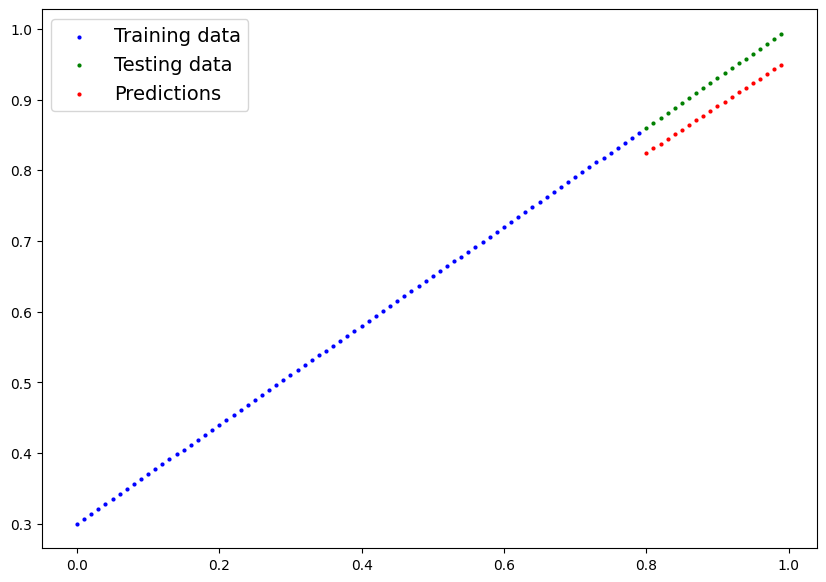

In [35]:
# Turn on eval mode
model_2.eval()

# Make predictions i.e. inference
with torch.inference_mode():
  y_preds_labels = model_2(X_test_regression)


# Plot data and predictions
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds_labels.cpu())

## 6. The missing piece: non-linearity

### 6.1 Recreating non-linear data (red & blue circles)

Artificial Neural networks are a large collection of Linear (straight line) and Non-linear (curved lines) functions which are potentially able to find patterns in data

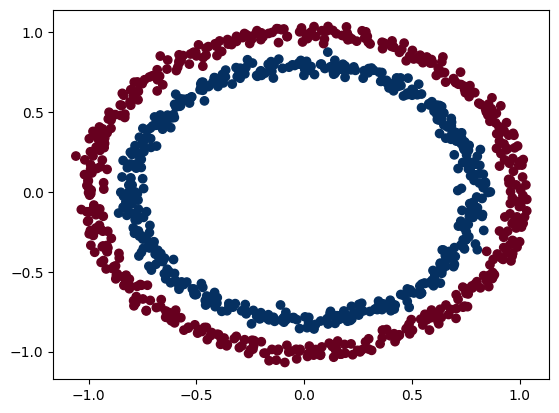

In [36]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [37]:
# Convert to tensors and split into train and test sets
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]
X_train.shape, y_train.shape

(torch.Size([800, 2]), torch.Size([800]))

### 6.2 Building a model with non-linearity

* Linear = straight line
* Non-linear = curved lines

In [38]:
# Build model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [39]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

### 6.3 Training a model with non-linearity

In [40]:
# Fit the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 2000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calculate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.68723, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.66322, Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757, Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.62145, Test Accuracy: 79.00%
Epoch: 1000 | Loss: 0.56818, Accuracy: 87.75% | Test Loss: 0.57378, Test Accuracy: 86.50%
Epoch: 1100 | Loss: 0.

### 6.4 Evaluating a model trained with non-linear activation functions

In [41]:
# Makes predictions
model_3.eval()

with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

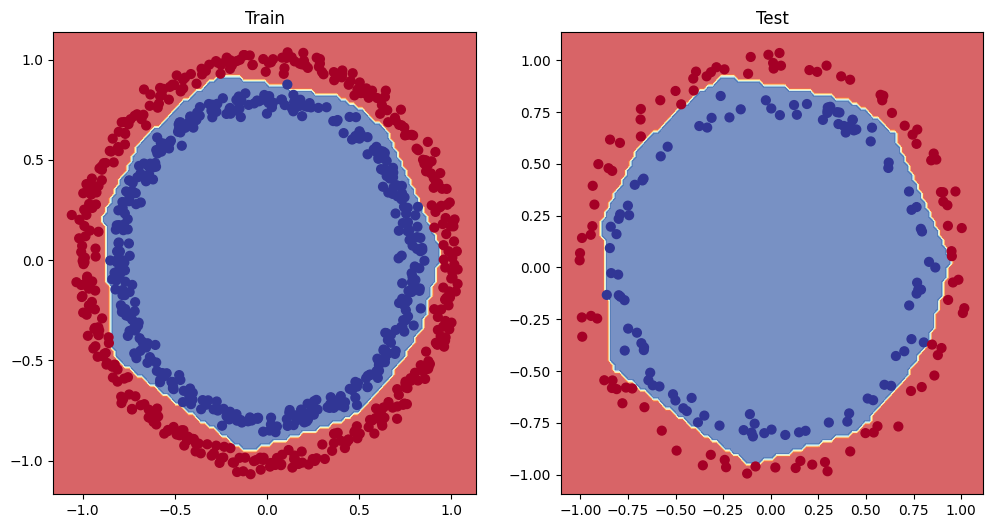

In [42]:
# Plot decision boundaries
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

## 7. Replicating non-linear activation functions using pure PyTorch

Neural networks, rather than us telling the model what to learn, we give it the tools to discover patterns in data and it tries to figure out the patterns on its own.

These tools are **linear** and **non-linear** functions.


In [43]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32) # `arange()` returns a 1-D tensor of size (end - start)/step
A, A.dtype

(tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
           2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.]),
 torch.float32)

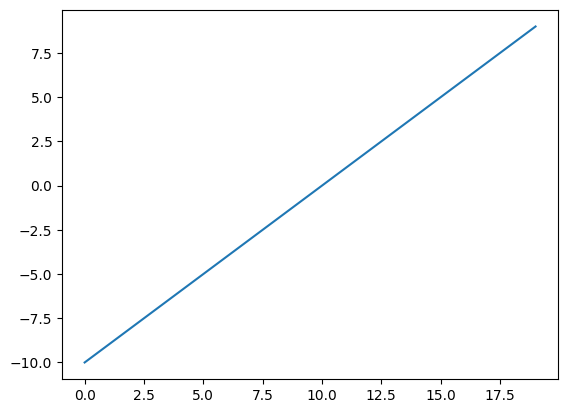

In [44]:
# Visualize the tensor
plt.plot(A)

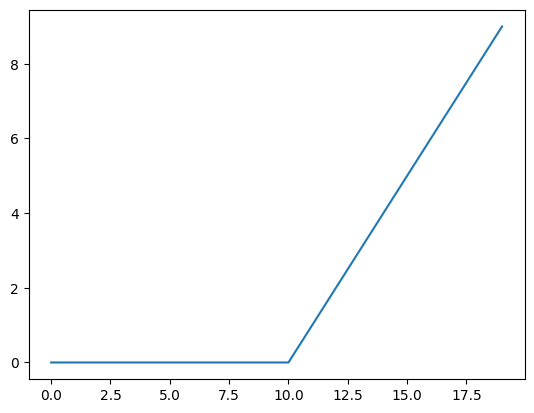

In [45]:
plt.plot(torch.relu(A))

In [46]:
# Lets define our own Relu function
# It's easier than expected
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.maximum(torch.tensor(0), x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

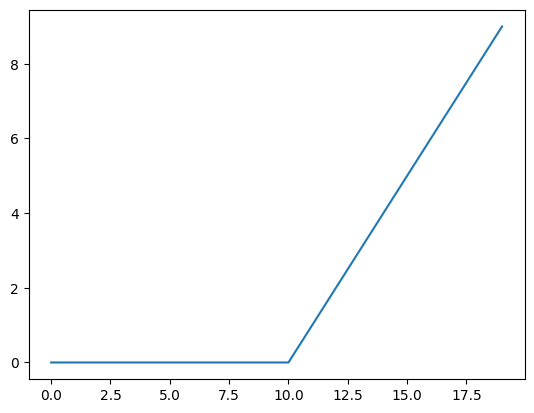

In [47]:
# Plot our custom `relu` function
plt.plot(relu(A))

In [48]:
# Just for kicks, lets define our very own Sigmoid function
def sigmoid(x):
  return 1 / ( 1 + torch.exp(-x))

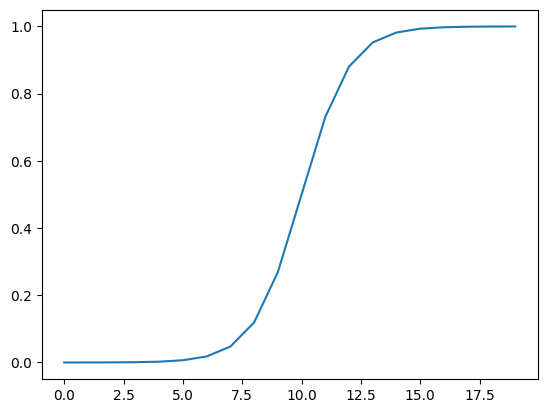

In [49]:
plt.plot(sigmoid(A))

## 8. Putting it all together with a multi-class classification problem

* Binary classification = one thing or another ( cat vs. dog, spam or not spam, fraud or not fraud)
* Multi-class classification = more than one thing or another (could be 3 things, could be thousand things)

### 8.1 Creating a toy multi-class dataset

X_blob_train shape: torch.Size([800, 2]), y_blob_train shape: torch.Size([800])
X_blob_test shape: torch.Size([200, 2]), y_blob_test shape: torch.Size([200])

First 10 values of X_blob_train:
tensor([[ 5.0405,  3.3076],
        [-2.6249,  9.5260],
        [-8.5240, -9.0402],
        [-6.0262, -4.4375],
        [-3.3397,  7.2175],
        [ 0.7755,  7.8018],
        [-4.2962,  9.9991],
        [ 3.8225,  2.5719],
        [-7.6469,  5.4421],
        [-3.7474,  8.5322]])

First 10 values of y_blob_train:
tensor([1., 0., 2., 2., 0., 0., 0., 1., 3., 0.])

First 10 values of X_blob_test:
tensor([[ 4.6675,  4.4878],
        [-7.9969,  6.8803],
        [-6.2801, -7.8571],
        [ 3.6833,  1.1767],
        [-0.1404, 10.1654],
        [-9.7570,  7.8658],
        [-4.4295, -8.5996],
        [-2.1731,  9.0332],
        [-9.2145, -7.5223],
        [-1.4015,  9.2713]])

First 10 values of y_blob_test:
tensor([1., 3., 2., 1., 0., 3., 2., 0., 2., 0.])


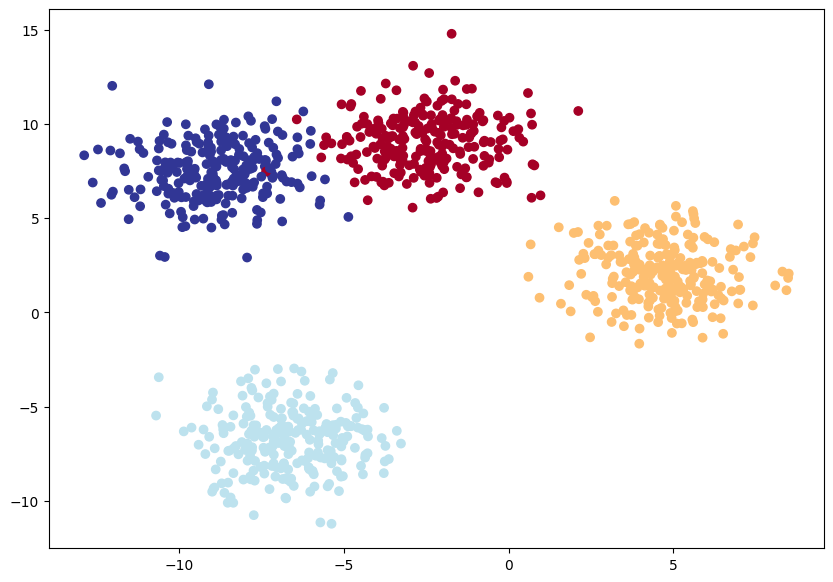

In [50]:
import torch
import matplotlib.pyplot as plt
# docs for make_blobs https://scikit-learn.org/dev/modules/generated/sklearn.datasets.make_blobs.html
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5, # give the clusters a little shake up
                            random_state=RANDOM_SEED)

# 2. Turn numpy data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)


# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)
# Print shapes of train and test tensors
print(f"X_blob_train shape: {X_blob_train.shape}, y_blob_train shape: {y_blob_train.shape}")
print(f"X_blob_test shape: {X_blob_test.shape}, y_blob_test shape: {y_blob_test.shape}")

# Print first 10 values of train and test data
print(f"\nFirst 10 values of X_blob_train:\n{X_blob_train[:10]}")
print(f"\nFirst 10 values of y_blob_train:\n{y_blob_train[:10]}")
print(f"\nFirst 10 values of X_blob_test:\n{X_blob_test[:10]}")
print(f"\nFirst 10 values of y_blob_test:\n{y_blob_test[:10]}")


# 4. Plot data (visualize, visualize visualize)
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:, 0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)


### 8.2 Building a multi-class classification model in PyTorch

In [51]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [52]:
# Build a multi-class classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """ Initializes multi-class classification model.

    Args:
      input_features (int): Number of input features to the model
      output_features (int): Number of output features (number of output classes)
      hidden_units (int): Number of hidden units between layers, default is 8

    Returns:
      An instance of th BlobModel multi-class classification model
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)


### 8.3 Create a loss function and an optimizer for a multi-class classification model


In [53]:
# Create a loss function for multi-class classification -> loss function measures how wrong our model's predictions are
loss_fn = nn.CrossEntropyLoss()

# Create an optimizer for multi-class classification -> optimizer updates our model parameters to try and reduce the loss
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)

### 8.4 Getting prediction probabilities for a multi-class PyTorch model

In order to evaluate and train and test our model, we need to convert our model's outputs (logits) to prediction probabilities and then to prediction labels.

Logits (raw output of the model) -> pred probs (use `torch.softmax`) -> pred labels (take the `argmax` of the prediction probabilities)

In [54]:
# Print out the raw output of our model
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))

y_logits[:10]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]], device='cuda:0')

In [55]:
# Convert our model's logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0')
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='cuda:0')


In [56]:
# Convert our model's prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')

In [57]:
y_blob_test

tensor([1., 3., 2., 1., 0., 3., 2., 0., 2., 0., 0., 1., 0., 0., 0., 3., 3., 2.,
        3., 3., 3., 0., 1., 2., 2., 2., 3., 0., 1., 0., 3., 1., 1., 3., 1., 2.,
        1., 3., 0., 2., 0., 3., 3., 2., 0., 3., 1., 1., 0., 3., 1., 0., 1., 1.,
        3., 2., 1., 1., 3., 2., 2., 0., 3., 2., 2., 0., 0., 3., 3., 0., 0., 3.,
        3., 3., 2., 3., 3., 3., 3., 1., 0., 2., 3., 2., 3., 3., 2., 3., 3., 2.,
        3., 3., 1., 3., 3., 3., 1., 0., 3., 2., 0., 0., 3., 0., 2., 3., 1., 0.,
        3., 2., 1., 1., 0., 2., 2., 3., 0., 0., 1., 2., 2., 3., 0., 1., 2., 0.,
        0., 0., 2., 3., 1., 2., 3., 2., 0., 3., 0., 0., 1., 1., 1., 0., 2., 2.,
        2., 2., 0., 3., 3., 2., 2., 1., 3., 2., 0., 0., 3., 3., 2., 1., 2., 0.,
        3., 2., 0., 3., 2., 0., 2., 2., 2., 0., 3., 1., 1., 1., 1., 1., 3., 1.,
        0., 2., 2., 1., 2., 2., 0., 1., 2., 2., 0., 0., 1., 3., 2., 0., 3., 1.,
        2., 1.])

### 8.5 Creating a training loop and testing loop for a multi-class PyTorch model

In [58]:
# Fit the multi-class model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set num of epochs
epochs = 1000

# Put the data on target device
# Convert target tensors to LongTensor
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.type(torch.LongTensor).to(device) # changed to LongTensor
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.type(torch.LongTensor).to(device) # changed to LongTensor


# Loop through data
for epoch in range(epochs):
  ### Training
  model_4.train()

  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy(y_true=y_blob_train,
                 y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step() # this is important fn, it will update the weights and biases based on the loss fn output

  ### Testing
  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy(y_true=y_blob_test,
                        y_pred=test_preds)

    # Print out what's happening
    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 1.1588, Acc: 40.38% | Test loss: 1.0755, Test acc: 48.00%
Epoch: 10 | Loss: 0.6448, Acc: 96.75% | Test loss: 0.6607, Test acc: 97.50%
Epoch: 20 | Loss: 0.4254, Acc: 98.50% | Test loss: 0.4307, Test acc: 100.00%
Epoch: 30 | Loss: 0.2529, Acc: 99.12% | Test loss: 0.2451, Test acc: 99.50%
Epoch: 40 | Loss: 0.1123, Acc: 99.25% | Test loss: 0.1023, Test acc: 99.50%
Epoch: 50 | Loss: 0.0663, Acc: 99.25% | Test loss: 0.0585, Test acc: 99.50%
Epoch: 60 | Loss: 0.0507, Acc: 99.25% | Test loss: 0.0429, Test acc: 99.50%
Epoch: 70 | Loss: 0.0430, Acc: 99.25% | Test loss: 0.0349, Test acc: 99.50%
Epoch: 80 | Loss: 0.0384, Acc: 99.25% | Test loss: 0.0299, Test acc: 99.50%
Epoch: 90 | Loss: 0.0352, Acc: 99.25% | Test loss: 0.0266, Test acc: 99.50%
Epoch: 100 | Loss: 0.0331, Acc: 99.25% | Test loss: 0.0243, Test acc: 99.50%
Epoch: 110 | Loss: 0.0316, Acc: 99.25% | Test loss: 0.0226, Test acc: 99.50%
Epoch: 120 | Loss: 0.0304, Acc: 99.25% | Test loss: 0.0213, Test acc: 99.50%
Epoch: 13

### 8.6  Making and evaluating predictions with PyTorch multi-class model

We've trained our model and now we need to do some predictions and plot that out.

- Both for testing and evaluation, we put the model into `eval()` mode, for training we put the model into `train()` mode.

- The code for *predictions* is very similar to code for *testing*.

- The features that we pass in for predictions are the same as test

In [59]:
# Make predictions
model_4.eval()

with torch.inference_mode():
  y_logits = model_4(X_blob_test)

print(f" First 10 values of y_logits (aka raw output): {y_logits[:10]} \n")

# Go from raw logits to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

print(f" First 10 values of y_pred_probs converted using softmax: {y_pred_probs[:10]}\n")


# Go from pred probs to get the index of the predicted value using argmax
y_preds = y_pred_probs.argmax(dim=1)
print(f"     First 10 values of y_preds: {y_preds[:10]}")
print(f" First 10 values of y_blob_test: {y_blob_test[:10]}")
print(f" Is y_preds equal to y_blob_test? {y_preds == y_blob_test}")

 First 10 values of y_logits (aka raw output): tensor([[ -2.3751,  10.9387, -10.2038, -11.3271],
        [ -2.1934,  -9.4839,  -6.3062,   5.2289],
        [ -4.9855,  -5.3790,   5.3840,  -4.3115],
        [ -3.0428,   8.1532,  -5.4971,  -6.6867],
        [  6.4903,  -2.8976, -12.3324,  -8.4675],
        [ -2.7724, -11.1928,  -7.4741,   6.3900],
        [ -4.3608,  -4.5814,   4.6890,  -3.5910],
        [  5.8017,  -6.8308,  -9.7351,  -4.1265],
        [ -6.3789,  -6.9228,   6.6638,  -5.5251],
        [  6.2822,  -5.5357, -10.3558,  -5.4748]], device='cuda:0') 

 First 10 values of y_pred_probs converted using softmax: tensor([[1.6516e-06, 1.0000e+00, 6.5756e-10, 2.1386e-10],
        [5.9742e-04, 4.0743e-07, 9.7751e-06, 9.9939e-01],
        [3.1372e-05, 2.1166e-05, 9.9989e-01, 6.1553e-05],
        [1.3729e-05, 9.9998e-01, 1.1797e-06, 3.5901e-07],
        [9.9992e-01, 8.3727e-05, 6.6890e-09, 3.1907e-07],
        [1.0490e-04, 2.3113e-08, 9.5250e-07, 9.9989e-01],
        [1.1735e-04, 9.4122

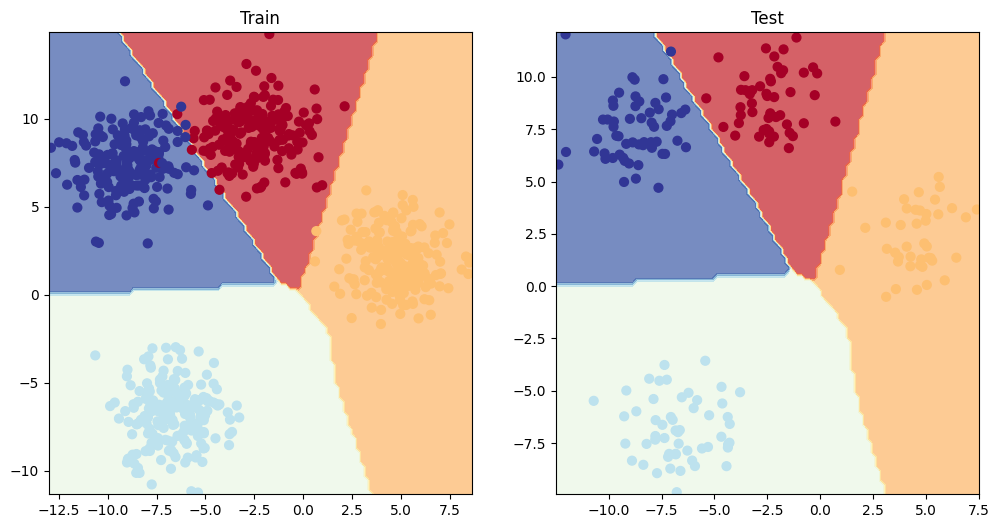

In [60]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9. A few more classification metrics.... (to evaluate our classification models)

* Accuracy - out of 100 models how many does our model get right?
* Precision
* Recall
* F1-score
* Confusion matrix
* Classification report

See this article to understand these different metrics in detail: https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c

[torchmetrics](https://lightning.ai/docs/torchmetrics/stable/) library is the preferred way to calculate these metrics.

In [62]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 49.6 MB/s eta 0:00:00


In [67]:
import torchmetrics
from torchmetrics import Accuracy # This line ensures that Accuracy is directly accessible

# Setup metric
torchmetric_accuracy = Accuracy(num_classes=4, task='multiclass').to(device)

# calculate accuracy
torchmetric_accuracy(y_preds, y_blob_test)

tensor(0.9950, device='cuda:0')